In [ ]:
!nvidia-smi

Thu Sep  2 00:45:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.96       Driver Version: 471.96       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |     37MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TEST_CSV_PATH = ''
IMAGE_PATH_TEST = 'AgeDB-images-with-solved-corrupted-files/'

RANDOM_SEED = 42
PATH = ''
NUM_CLASSES = 97
BATCH_SIZE = 128
GRAYSCALE = False
NUM_WORKERS = 0

In [ ]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'evaluation_AgeDB.log')

In [ ]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'\n-------------------EVALUATION RESULTS---------------')

In [ ]:
for entry in header:
  print(entry)




Last Run: 2021-09-02 00:46:02.224117+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Output Path: Models_and_Logs/Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-200-withourLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 256
Grayscale: False

-------------------EVALUATION RESULTS---------------


In [ ]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [ ]:
df = pd.read_csv(TEST_CSV_PATH, index_col=1)
df

,file,label
age,,
35,0_MariaCallas_35_f.jpg,33
40,1_MariaCallas_40_f.jpg,38
28,10_MariaCallas_28_f.jpg,26
52,100_PaulAnka_52_m.jpg,50
1,1000_StephenHawking_1_m.jpg,0
...,...,...
54,9995_GlennClose_54_f.jpg,52
56,9996_GlennClose_56_f.jpg,54
58,9997_GlennClose_58_f.jpg,56


In [ ]:
class AgeDBDataset(Dataset):
    """Custom Dataset for loading AgeDB face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - 1 - label)
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels

    def __len__(self):
        return self.y.shape[0]

In [ ]:
custom_transform_test = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop((224, 224)),
                                        transforms.ToTensor()])

test_dataset = AgeDBDataset(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH_TEST,
                              transform=custom_transform_test,
                              items = None
                            )

# Dataset Entity Distribution Analysis

In [ ]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

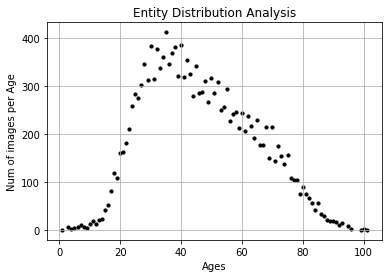

label		Age		Count
0 		 1 		 1
1 		 3 		 8
2 		 4 		 2
3 		 5 		 4
4 		 6 		 8
5 		 7 		 11
6 		 8 		 8
7 		 9 		 6
8 		 10 		 13
9 		 11 		 20
10 		 12 		 14
11 		 13 		 22
12 		 14 		 23
13 		 15 		 43
14 		 16 		 52
15 		 17 		 82
16 		 18 		 120
17 		 19 		 110
18 		 20 		 161
19 		 21 		 163
20 		 22 		 183
21 		 23 		 212
22 		 24 		 259
23 		 25 		 284
24 		 26 		 275
25 		 27 		 304
26 		 28 		 347
27 		 29 		 313
28 		 30 		 385
29 		 31 		 316
30 		 32 		 378
31 		 33 		 338
32 		 34 		 362
33 		 35 		 413
34 		 36 		 347
35 		 37 		 370
36 		 38 		 382
37 		 39 		 321
38 		 40 		 386
39 		 41 		 320
40 		 42 		 356
41 		 43 		 325
42 		 44 		 281
43 		 45 		 342
44 		 46 		 287
45 		 47 		 289
46 		 48 		 311
47 		 49 		 267
48 		 50 		 317
49 		 51 		 287
50 		 52 		 310
51 		 53 		 250
52 		 54 		 258
53 		 55 		 294
54 		 56 		 227
55 		 57 		 243
56 		 58 		 246
57 		 59 		 213
58 		 60 		 245
59 		 61 		 207
60 		 62 		 238
61 		 63 		 218
62 		 64 		 193
63 		 65 		 231

In [ ]:
dataset_analysis(test_dataset)

# Dataset Loader

In [ ]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

In [ ]:
print(f"No. of Batches for AgeDB: {len(test_loader)}")

No. of Batches for AgeDB: 65


# Initialize Model, and Optimizer

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

"""Preparaing the model to evaluate on AgeDB"""
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 1, bias=False)
model.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float())

print(model)

# Evaluation

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(tqdm(data_loader)):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    logits = logits + model.linear_1_bias
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

# Testing on AgeDB

In [ ]:
lists = [i for i in range(1,201)] # number epochs to evaluate
result_dict = {}

start_time = time.time()
test_mae = test_mse = test_acc = 0.0
for i in tqdm(lists):
  model_name = f'Epoch_{i}_model.pt'
  model.load_state_dict(torch.load(os.path.join(PATH, model_name)))
  model.to(DEVICE)
  model.eval()

  with torch.set_grad_enabled(False):
    str0 = f'---------------{model_name}-----------------\n'
    print(str0)
    test_mae, test_mse, test_acc = compute_mae_and_mse(model, test_loader, device=DEVICE)
    
    result_dict[model_name] = test_mae    
    str1 = f'MAE/RMSE/ACC: | AGEDB-Test: {test_mae}/{test_mse}/{test_acc}%\n'
    str = str0+str1
    print(str1)
    with open(LOGFILE, 'a') as f: f.write(f'{str}\n')
    
time_elapsed = format((time.time() - start_time)/60, ".3f")
str = f'Time elapsed: {time_elapsed}mins\n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}')

In [ ]:
result_list = sorted(result_dict.items(), key=lambda item:float(item[1]))

In [ ]:
with open(LOGFILE, 'a') as f:
    f.write(f'\n\n----Result in Sorted Order----\n\n')
    for item in result_list:
        string = f'{item[0]} {item[1]}\n'
        f.write(string)
        print(string)
        f.flush()